In [64]:
import torch
import torch_geometric
from torch_geometric import utils
from torch_geometric.nn import SAGEConv, MessagePassing
from torch_geometric.typing import Adj, OptPairTensor, Size
from torch_sparse import SparseTensor, matmul
import torch.nn as nn
import torch.nn.functional as F

from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np

from typing import Union, Tuple

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
ec_hic = np.load('data/GBM39ec_5k_collapsed_matrix.npy')
hsr_hic = np.load('data/GBM39HSR_5k_collapsed_matrix.npy')

In [4]:
ec_df = pd.read_csv('data/ec_cleaned.csv')
hsr_df = pd.read_csv('data/hsr_cleaned.csv')

In [5]:
hsr_feats = torch.tensor(hsr_df[['read_count', 'total_genes']].to_numpy())
hsr_labels = torch.zeros(hsr_feats.shape[0])

ec_feats = torch.tensor(ec_df[['read_count', 'total_genes']].to_numpy())
ec_labels = torch.ones(ec_feats.shape[0])

In [6]:
def hic_to_sparse(hic_mat):
    adj_mat = np.triu(hic_mat)
    sparse_adj = coo_matrix(adj_mat)

    return utils.from_scipy_sparse_matrix(sparse_adj)

In [7]:
hsr_edge_index, hsr_edge_attr = hic_to_sparse(hsr_hic)
hsr_graph = torch_geometric.data.Data(edge_index = hsr_edge_index, edge_attr = hsr_edge_attr, x = hsr_feats, y = hsr_labels)

ec_edge_index, ec_edge_attr = hic_to_sparse(ec_hic)
ec_graph = torch_geometric.data.Data(edge_index = ec_edge_index, edge_attr = ec_edge_attr, x = ec_feats, y = ec_labels)

In [8]:
x = torch.cat([ec_feats, hsr_feats], dim=0)
hsr_edge_index = hsr_edge_index + ec_labels.shape[0]
edge_index = torch.cat([ec_edge_index, hsr_edge_index], dim=1)
edge_attr = torch.cat([ec_edge_attr, hsr_edge_attr], dim=0)
labels = torch.cat([ec_labels, hsr_labels], dim=0)

G = torch_geometric.data.Data(edge_index = edge_index, edge_attr = edge_attr, x = x, y = labels)

In [27]:
class SAGEConvCat(MessagePassing):
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, normalize: bool = False,
                 bias: bool = True, **kwargs):  
        super(SAGEConvCat, self).__init__(aggr='mean', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = nn.Linear(in_channels[0] * 2, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()

    def forward(self, x: Union[torch.Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: torch.Tensor, size: Size = None) -> torch.Tensor:
        
        x = x.float()
        edge_attr = edge_attr.float()
        edge_attr = torch.log1p(edge_attr)
    
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)
        out = torch.cat([x, out], dim=-1)
        
        out = self.lin_l(out)
        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        return x_j * edge_attr.view(-1, 1)

    def message_and_aggregate(self, adj_t: SparseTensor,
                              x: OptPairTensor) -> torch.Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)


In [50]:
class GraphSAGE(nn.Module):
    def __init__(self, num_feat, graph_conv_layer_sizes, lin_hidden_sizes, num_classes):
        super().__init__()
        self.embeds = None

        self.conv1 = SAGEConvCat(graph_conv_layer_sizes[0], graph_conv_layer_sizes[1])
        self.conv2 = SAGEConvCat(graph_conv_layer_sizes[1], graph_conv_layer_sizes[2])
        
        self.lin1 = nn.Linear(lin_hidden_sizes[0], lin_hidden_sizes[1])
        self.lin2 = nn.Linear(lin_hidden_sizes[1], lin_hidden_sizes[2])
            
        self.loss_calc = nn.CrossEntropyLoss()
        self.torch_softmax = nn.Softmax(dim=1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.conv1(x, edge_index, edge_attr)
        h = torch.relu(h)
        h = self.conv2(h, edge_index, edge_attr)
        h = torch.relu(h)

        self.embeds = h
            
        scores = h
        scores = self.lin1(scores)
        scores = torch.relu(scores)
        scores = self.lin2(scores)
        
        return scores

    def loss(self, scores, labels):
        xent_loss = self.loss_calc(scores, labels)
        return xent_loss

    def calc_softmax_pred(self, scores):
        softmax = self.torch_softmax(scores)
        predicted = torch.argmax(softmax, 1)
        return softmax, predicted

    def get_embeds(self):
        if self.embeds is not None:
            return self.embeds

        print("Untrained Model: Please train model first")
        return None
    

In [51]:
def split_data(G, train_ratio=0.8, test_ratio=0.2, seed=42):
    assert train_ratio + test_ratio == 1, "Ratios must sum to 1."
    
    torch.manual_seed(seed)  # For reproducibility
    
    num_nodes = G.x.shape[0]  # Total number of nodes
    indices = torch.randperm(num_nodes)  # Shuffle node indices randomly
    
    # Compute split size
    train_size = int(train_ratio * num_nodes)
    
    # Assign indices to train and test sets
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    # Create boolean masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    test_mask[test_idx] = True

    # Attach masks to the graph
    G.train_mask = train_mask
    G.test_mask = test_mask

    return G

In [52]:
def train(model, optimizer, graph, device):
    model.train()
    optimizer.zero_grad()
    scores = model(graph)
    loss = model.loss(scores[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss.item(), scores

def test(model, graph, device):
    model.eval()
    scores = model(graph)
    softmax, predicted = model.calc_softmax_pred(scores)
    accs = []
    for mask in [graph.train_mask, graph.test_mask]:
        correct = (predicted[mask] == graph.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    
    return tuple(accs)

In [53]:
num_features = G.num_node_features
num_classes = 2
graph_sage_layer_sizes = [num_features,8,16]
linear_layer_sizes = [16, 8, num_classes]

# Hyperparameters
learning_rate = 0.01
weight_decay = 5e-4
num_epochs = 1000
#dropout_value = 0.5

# Initialize the model, optimizer, and send to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(num_features, graph_sage_layer_sizes, linear_layer_sizes, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#model.dropout_value = dropout_value

# Assign train and test masks to graph
G.x = G.x.float()
G.y = G.y.long()
G = split_data(G)
G = G.to(device)

In [54]:
train_accs = []
test_accs = []

# Training loop - Entire graph in one model
for epoch in range(1, num_epochs + 1):
    loss, _ = train(model, optimizer, G, device)
    train_acc, test_acc = test(model, G, device)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    if epoch % 100 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 100, Loss: 0.6494, Train Acc: 0.6484, Test Acc: 0.7030
Epoch 200, Loss: 0.5838, Train Acc: 0.8703, Test Acc: 0.8416
Epoch 300, Loss: 0.4357, Train Acc: 0.8180, Test Acc: 0.8614
Epoch 400, Loss: 0.5914, Train Acc: 0.9352, Test Acc: 0.9208
Epoch 500, Loss: 0.2272, Train Acc: 0.9526, Test Acc: 0.9406
Epoch 600, Loss: 0.2007, Train Acc: 0.9576, Test Acc: 0.9406
Epoch 700, Loss: 0.1855, Train Acc: 0.9626, Test Acc: 0.9406
Epoch 800, Loss: 0.1193, Train Acc: 0.9651, Test Acc: 0.9604
Epoch 900, Loss: 0.0903, Train Acc: 0.9751, Test Acc: 0.9703
Epoch 1000, Loss: 0.0641, Train Acc: 0.9875, Test Acc: 0.9703


In [60]:
embeds = model.get_embeds().cpu().detach().numpy()
embeds.shape

(502, 16)

In [102]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeds = pca.fit_transform(embeds)
pca_embeds.shape

(502, 2)

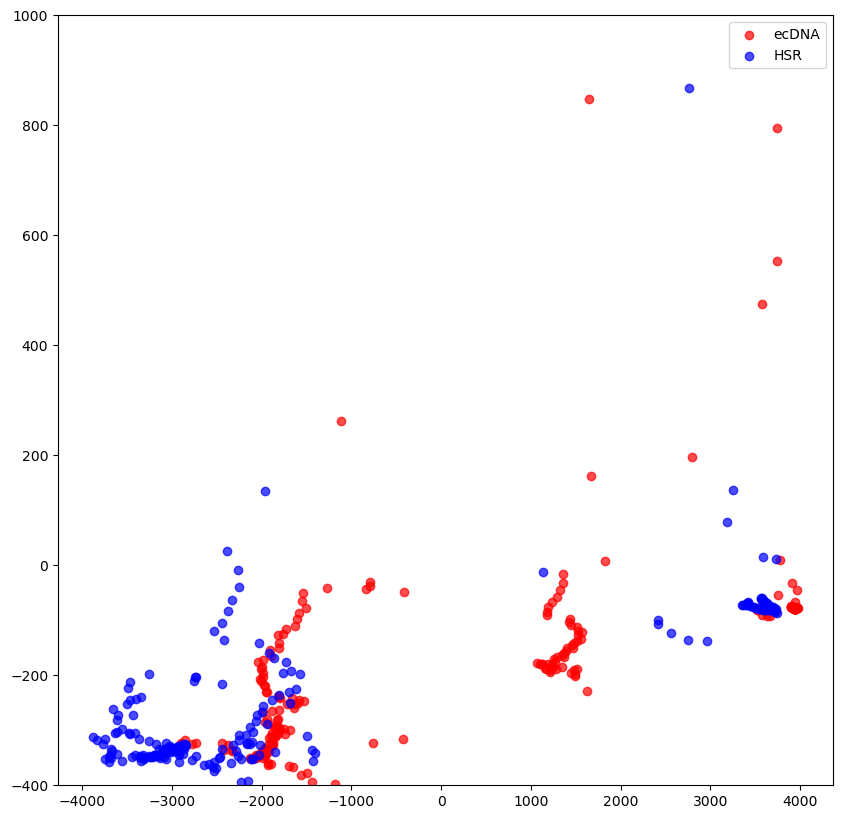

In [122]:
ec_mask = (G.y == 1).cpu()

plt.figure(figsize=(10,10))
plt.scatter(pca_embeds[:, 0][ec_mask], pca_embeds[:, 1][ec_mask], color='red', label='ecDNA', alpha=0.7)
plt.scatter(pca_embeds[:, 0][~ec_mask], pca_embeds[:, 1][~ec_mask], color='blue', label='HSR', alpha=0.7)
plt.ylim(-400, 1000)
plt.legend()
plt.show()

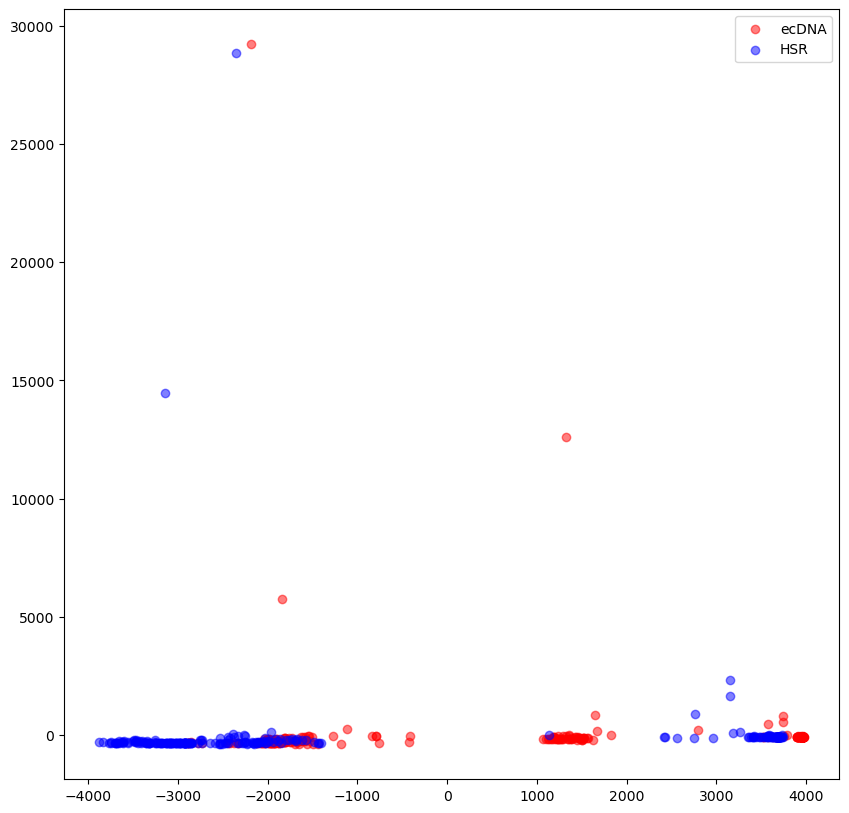

In [124]:
plt.figure(figsize=(10,10))
plt.scatter(pca_embeds[:, 0][ec_mask], pca_embeds[:, 1][ec_mask], color='red', label='ecDNA', alpha=0.5)
plt.scatter(pca_embeds[:, 0][~ec_mask], pca_embeds[:, 1][~ec_mask], color='blue', label='HSR', alpha=0.5)
plt.legend()
plt.show()